# Identificação não Paramétrica

**Descrição do documento:** Análise não paramétrica do módulo Peltier
 
**Autor:** William Henrique Azevedo Martins

## Sumário

1. [Descrição](#descrição-dos-experimentos)
2. [Resultados dos Experimentos](#2-resultados-dos-experimentos)
    - [Resultados Malha 1](#malha-1)
    - [Resultados Malha 2](#malha-2)
    - [Pertubação](#análise-da-pertubação)
3. [Resultados dos Experimentos com Pertubação]()


## 1. Descrição dos experimentos

Foi realizado a excitação individual das malhas do  Peltier, aplicando um sinal do tipo pulso retangular no PWM de entrada de cada malha, o PWM controla a quantidade de corrente elétrica fornecida para o módulo Peltier, fazendo-o esquentar ou resfriar de acordo com a intensidade e sentido da corrente.

**Etapas do experimento:**
- Configuração inicial / Ponto de operação: Os PWM (MV1 e MV2) das duas malhas foram definidos em zero inicialmente, nessa etapa é possível caracterizar a influência do ambiente no processo.
- Etapa 1: Foi adicionado um pulso retangular com duração aproximada de 55 minutos no PWM da entrada 1, sendo tempo suficiente para o valor de temperatura estabilizar (PV1).
- Etapa 2: Aguardou-se o sistema voltar para o ponto de operação.
- Etapa 3: Foi adicionado um pulso retangular com duração aproximada de 55 minutos na entrada da malha 2.

Por meio da etapa inicial, foi possível observar que o ambiente em que o processo está localizado introduz uma pertubação quasi-estacionaria conforme pode ser observado nos gráficos da sessão 2.

In [4]:
import sys
sys.path.append('..')
import numpy as np
# %matplotlib widget
import matplotlib.pyplot as plt
from util import plot_pv_mv, plot_sinal, carregar_dados, remover_valor_inicial

dados1_np = carregar_dados('../resultados/malha1_pulso10p_novo/pv_mv_data.csv')
dados2_np = carregar_dados('../resultados/malha2_pulso10p/pv_mv_data.csv')
dados1_cp = carregar_dados('../resultados/malha1_pulso50p/pv_mv_data.csv')
dados2_cp = carregar_dados('../resultados/malha2_pulso50p/pv_mv_data.csv')

def obter_intervalo_degrau(x):
    idx =  np.nonzero(x)[0]
    x_start = idx[0]
    x_end = idx[-1]
    return x_start, x_end

## 2. Resultados dos experimentos

O experimento foi mais longo para poder observar o efeito da pertubação no sistema.

### Malha 1

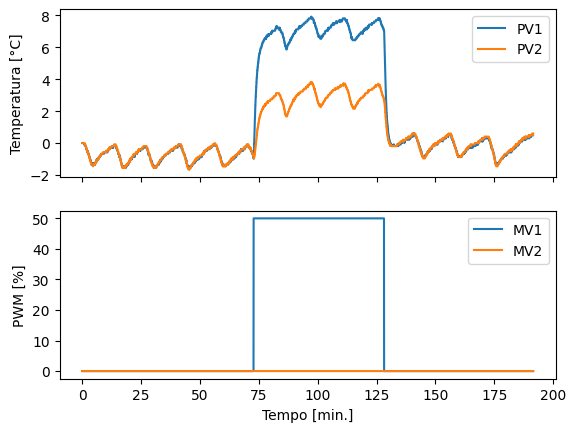

In [5]:
plot_pv_mv(dados1_cp, f=remover_valor_inicial);

### Malha 2 

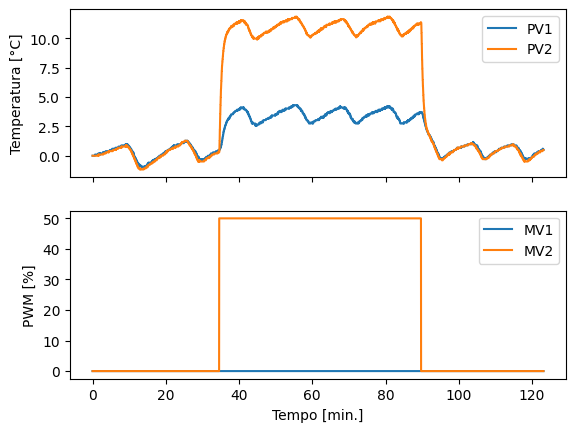

In [7]:
plot_pv_mv(dados2_cp, f=remover_valor_inicial);

### Análise da pertubação

A seguir será analisado as componentes de frequência da pertubação, para averiguar sua influência na identificação  não parâmétrica

A pertubação pode ser observada isoladamente quando as malhas não estão excitadas ($MV1 = MV2 = 0$), de tal modo que a média da pertubação é a temperatura ambiente.

Amplitude da pertubação = 0.7299999999999986
Média da pertubação = 28.062951851851853


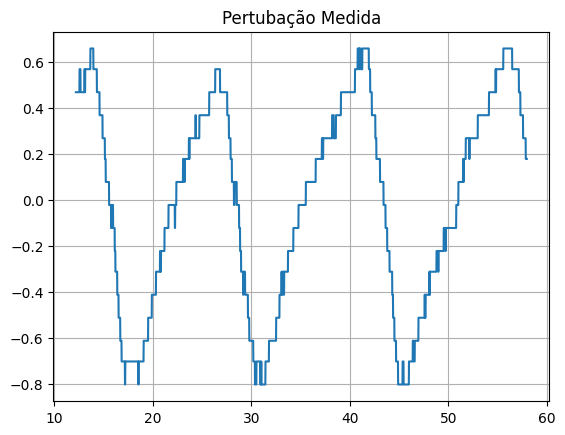

In [10]:
from matplotlib.widgets import Cursor
fig, ax = plt.subplots()
plt.title("Pertubação Medida")
intervalo = (12*60, 12*60+15*60*3)
range_pertubacao = [12*60, 12*60+15*60*3]
t_int = dados1_cp["t"][intervalo[0]:intervalo[1]]
pertubacao_malha1 = dados1_cp["pv1"][intervalo[0]:intervalo[1]]
d_mean = np.mean(pertubacao_malha1)

plt.plot(t_int, pertubacao_malha1 - d_mean)
plt.grid(True)

amplitude_pertubacao1 = (max(pertubacao_malha1) - min(pertubacao_malha1)) * 0.5
print(f"Amplitude da pertubação = {amplitude_pertubacao1}")
print(f"Média da pertubação = {d_mean}")

cursor = Cursor(ax, useblit=True, color='red', linewidth=1)
# pontos = plt.ginput(2)
# t_subida = pontos[0][0]
# t_descida = pontos[1][0]
# print("Tempo de subida:", t_subida)
# print("Tempo de descida:", t_descida)

Do gráfico acima, é possível medir o tempo de subida, o período de oscilação e a amplitude do sinal.

- Tempo de subida medido: 10,53 minutos
- Período medido: 14,43 minutos
- Amplitude: 0,73 °C

Pode-se considerar que a influência em ambas as malhas são a mesma.

A frequência fundamental da pertubação:
$$\omega_0 = 2\pi/T$$

In [11]:
print("frequência fundamental pertubação:", round(2*np.pi/(14.34*60.0), 7), "rad/s")

frequência fundamental pertubação: 0.0073026 rad/s


TypeError: Axes.stem() got an unexpected keyword argument 'use_line_collection'

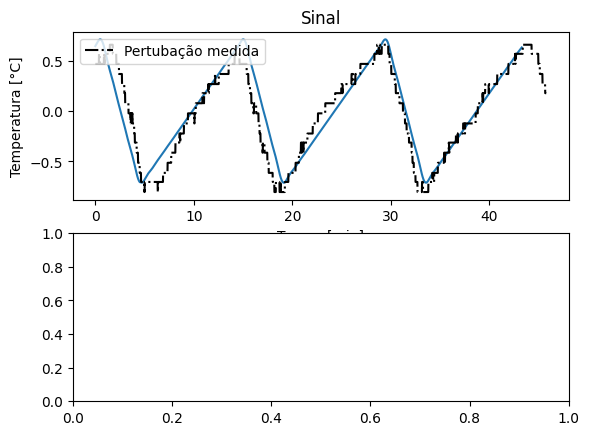

In [12]:
from sinais.serie_fourier.triangular import compute_coef

A = 0.73 * 2.0
ts = 10.53 * 60  # periodo
T = 14.43 * 60 # tempo de subida
n_max = 15

i = list(range(1, n_max))
time = np.linspace(0, 3*T, 500)
sinal_coefs = list(map(lambda x: compute_coef(x, ts, T), i))
sinal_coefs = np.array(sinal_coefs)
a_ns = []
b_ns = []
fase = np.pi/2
sinal_triangular = 0
for n_i, [a_n, b_n] in enumerate(sinal_coefs):
    a_ns.append(A*a_n)
    b_ns.append(A*b_n)
    n_i = n_i + 1
    arg = 2*np.pi*n_i*(time)/T
    sinal_triangular += a_n*np.cos(arg) + b_n*np.sin(arg)
# sinal_triangular += 1/4
sinal_triangular *= A

fig, (ax_sinal, ax_coefs) = plt.subplots(2, 1)

ax_sinal.set_title("Sinal")
ax_sinal.set_xlabel("Tempo [min]")
ax_sinal.set_ylabel("Temperatura [°C]")
ax_sinal.plot(time / 60.0, np.roll(sinal_triangular, 53))
t_= t_int - t_int[0]
ax_sinal.plot(t_, pertubacao_malha1 - d_mean, 'k-.', label='Pertubação medida')
ax_sinal.legend()

# sinal_coefs = np.array()
ax_coefs.stem(i, sinal_coefs[:, 0], 'b', markerfmt='*b', label='$a_n$', use_line_collection=True)
ax_coefs.stem(i, sinal_coefs[:, 1], 'r', markerfmt='or', label='$b_n$', use_line_collection=True)
ax_coefs.set_ylabel("$(a_n, b_n)$/Ganho");
ax_coefs.set_xlabel("N° coeficiente");
ax_coefs.legend();

fig.tight_layout();

In [13]:
print("Coeficientes do sinal de pertubação:")
w_d = []
for n_i in range(1, 11):
    w_d.append(2*np.pi/T * n_i)
    print(f" omega_{n_i:02d} = {2*np.pi/T * n_i:.6f} rad/s -> a_n = {a_ns[n_i-1]:.4f}, b_n = {b_ns[n_i-1]:.4f}")

Coeficientes do sinal de pertubação:
 omega_01 = 0.007257 rad/s -> a_n = -0.4227, b_n = -0.3720
 omega_02 = 0.014514 rad/s -> a_n = -0.1845, b_n = 0.0236
 omega_03 = 0.021771 rad/s -> a_n = -0.0261, b_n = 0.0387
 omega_04 = 0.029028 rad/s -> a_n = -0.0030, b_n = -0.0114
 omega_05 = 0.036285 rad/s -> a_n = -0.0239, b_n = -0.0121
 omega_06 = 0.043543 rad/s -> a_n = -0.0179, b_n = 0.0072
 omega_07 = 0.050800 rad/s -> a_n = -0.0017, b_n = 0.0048
 omega_08 = 0.058057 rad/s -> a_n = -0.0028, b_n = -0.0050
 omega_09 = 0.065314 rad/s -> a_n = -0.0088, b_n = -0.0019
 omega_10 = 0.072571 rad/s -> a_n = -0.0048, b_n = 0.0036


## 3.Identificação não paramétrica

Nessa sessão serão analisados os sinais coletados do processo

A notação utilizada a seguir será na forma $y_{ab}$ em que $a$ é a saída medida na malha $a$ em decorrência do sinal aplicado na entrada da malha $b$.

O Trecho de código a seguir, faz a mudança de nomeclatura e particiona no tempo as amostras dos sinais coletados a partir do instante em que o pulso retangular foi aplicado até o comprimento aplicado.

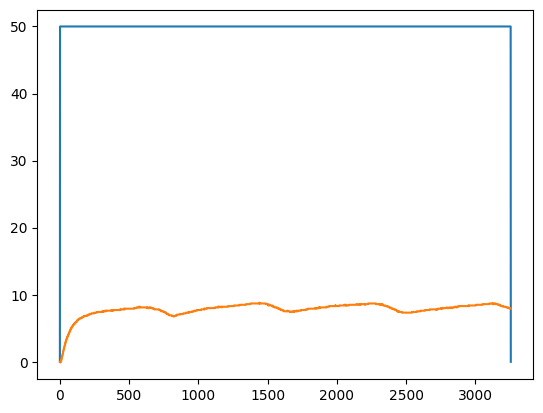

In [100]:
dados1 = dados1_cp
dados2 = dados2_cp

# descompacta t, pv1, pv2, mv1, mv2
_, y11, y21, u1, _ = dados1.values()
_, y12, y22, _, u2 = dados2.values()

t1_start, t1_end = obter_intervalo_degrau(u1)
t2_start, t2_end = obter_intervalo_degrau(u2)

t1_start -= 1
t2_start -= 1
# t1_end   += 1


duracao1 = t1_end - t1_start
duracao2 = t2_end - t2_start

# t1_end -= duracao1 // 3
# t2_end -= duracao2 // 3

t1_end   += 2
t2_end   += 2

# t1_start, t1_end = 0, len(u1)
# t2_start, t2_end = 0, len(u2)

y11 = remover_valor_inicial(y11[t1_start:t1_end])
y21 = remover_valor_inicial(y21[t1_start:t1_end])
u1  = u1[t1_start:t1_end]

y12 = remover_valor_inicial(y12[t2_start:t2_end])
y22 = remover_valor_inicial(y22[t2_start:t2_end])
u2 = u2[t2_start:t2_end]

plt.plot(u1)
plt.plot(y11)

Transformada de Fourier do Pulso Retangular de duração $T$
\begin{equation*}
    x(t) = 1, \quad 0 \leq t \leq T
\end{equation*}

\begin{equation*}
    F(j\omega) = \frac{1 - exp(-j\omega T)}{j\omega} = \frac{sin(\omega T/2)}{T/2} * exp(-j\omega \frac{T}{2})
\end{equation*}

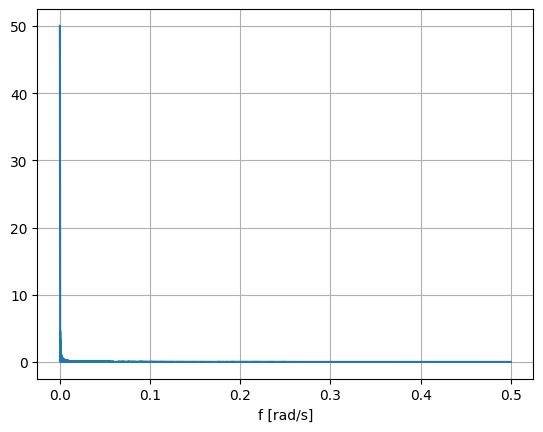

In [144]:
def fourier_pulse_signal(omega, T):
    """"Calcula a Transformada de Fourier do sinal de pulso retangular de período T."""
    num = np.sinc(omega*T/2)*np.exp(-1j*omega*T/2)
    den = T/2
    den = 1
    return num / den

N = 2**14
dt = 2.0
# omega = np.linspace(0*np.pi, 2*np.pi, N)
omega = np.arange(N) / (dt * N) * 2*np.pi
L = np.arange(1, np.floor(N / 2), dtype=int)

u1_jw = 50*fourier_pulse_signal(omega, T=(t1_end - t1_start))
# u2_jw = fourier_pulse_signal(omega, T=(t2_end - t2_start))
plt.plot(omega / 2 / np.pi, abs(u1_jw))
plt.xlabel('f [rad/s]')
plt.grid()
# plt.plot(omega, 20*np.log10(abs(u2_jw)))

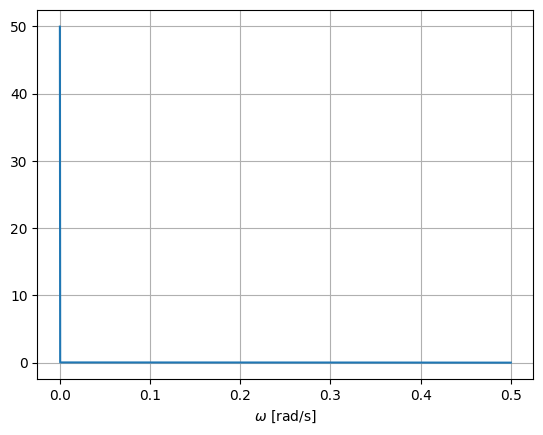

In [143]:
import scipy.fft as fft # transformada rápida de Fourier

def compute_fft(x, d = 2.0, n = None):
    
    X = fft.fft(x, n)
    L = len(X)
    
    P2 = abs(X / len(X))
    P1 = P2[0:L//2+1]

    freq = np.arange(0, L//2+1) / (d * L//2)

    return freq, P1

freq, u1_jw = compute_fft(u1)
plt.plot(freq, abs(u1_jw))
plt.xlabel('$\\omega$ [rad/s]')
plt.grid()

In [127]:


freq = np.arange(len(u1)//2) / (2.0 * len(u1))
a, b = compute_fft(u1)
plt.plot(abs(b[:]))
len(a)

ValueError: too many values to unpack (expected 2)

xdb = 20*log10(x)
10^xdb = 10^20*x

### Transformada de Fourier dos Sinais coletados

A seguir, serão plotado os sinais amostrados no domínio da frequência utilizando a transformada discreta de Fourier (FFT).

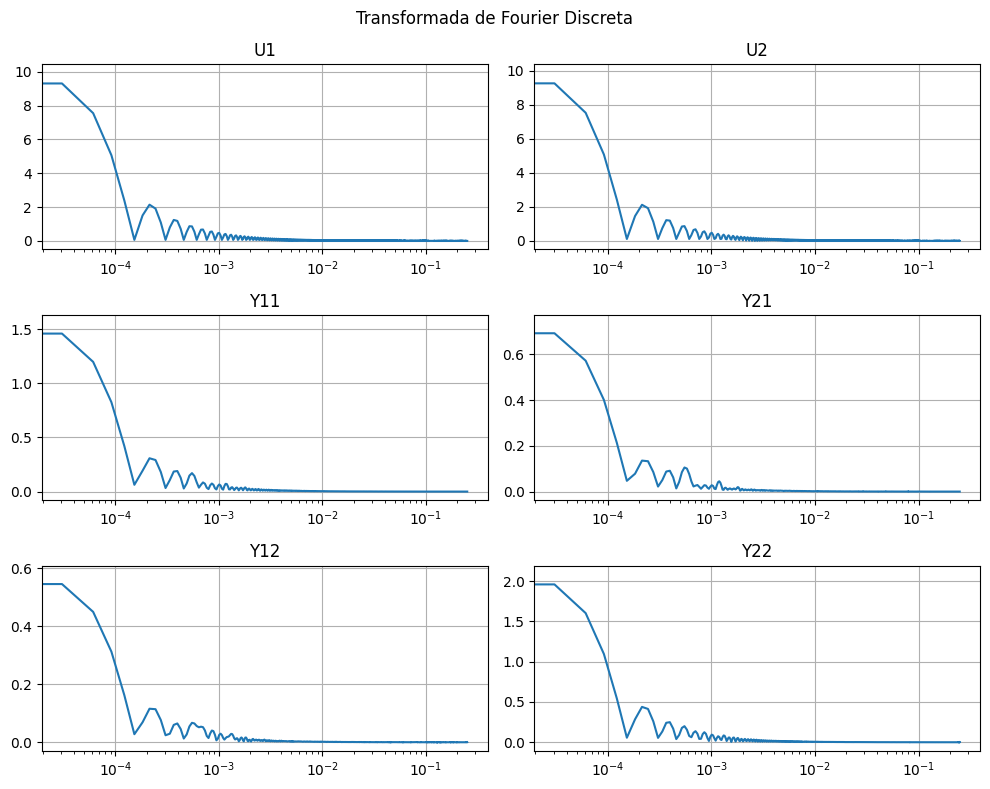

In [82]:


def plot_mag(w, x, ax=None):
    # plt.plot((np.abs(x)))
    
    if ax is None:
        ax = plt
    ax.semilogx(w, np.abs(x))




def post_fft(x, N = N):
    x_abs = np.abs(x[:N//2 + 1]) / N
    # x_abs *= 2.0
    # x_abs[0] /= 2.0
    # x_abs[-1] /=2.0

    return x_abs

# u1 = u1 / 100.0
# u2 = u2 / 100.0

L = np.arange(N)

u1_jw =  fft.fft(u1 , n = N)
u2_jw =  fft.fft(u2 , n = N)
y11_jw = fft.fft(y11, n = N)
y21_jw = fft.fft(y21, n = N)
y12_jw = fft.fft(y12, n = N)
y22_jw = fft.fft(y22, n = N)

fig, axes = plt.subplots(3, 2, figsize=(10, 8))
ax_u1, ax_u2, ax_y11, ax_y21, ax_y12, ax_y22 = axes.ravel()
for ax in axes.ravel():
    ax.grid(True)

ax_u1.set_title("U1")
ax_u2.set_title("U2")
ax_y11.set_title("Y11")
ax_y21.set_title("Y21")
ax_y12.set_title("Y12")
ax_y22.set_title("Y22")

plot_mag(omega[:N//2+1], post_fft( u1_jw, N=N), ax_u1)
plot_mag(omega[:N//2+1], post_fft( u2_jw, N=N), ax_u2)
plot_mag(omega[:N//2+1], post_fft(y11_jw, N=N), ax_y11)
plot_mag(omega[:N//2+1], post_fft(y21_jw, N=N), ax_y21)
plot_mag(omega[:N//2+1], post_fft(y12_jw, N=N), ax_y12)
plot_mag(omega[:N//2+1], post_fft(y22_jw, N=N), ax_y22)

fig.suptitle("Transformada de Fourier Discreta")
fig.tight_layout();

### Sistemas Identificados

Com a resposta em frequência dos sinais, podemos identificar o sistema
$$\mathbf{Y} = \mathbf{G}\cdot \mathbf{U}$$

tal que $$\mathbf{Y} = [Y_{1} \quad Y_{2}]^T \quad \mathbf{U} = [U_{1} \quad U_{2}]^T \quad $$

\begin{equation*}
\mathbf{G} = \begin{bmatrix} G_{11} &  G_{12} \\  G_{21} &  G_{22} \end{bmatrix}
\end{equation*}

Pelo principio da superposição, temos:

\begin{equation*}
Y_{11} = G_{11}U_1 \quad Y_{12} = G_{12}U_2 \quad Y_{21} = G_{21}U_1 \quad Y_{22} = G_{22}U_2
\end{equation*}

C:\Users\willi\AppData\Local\Temp\ipykernel_1940\1340939094.py:17: RuntimeWarning: divide by zero encountered in divide
  g11_abs = y11_abs / u1_abs


0.17813253968253934 0.17877963376516243
0.001155001155001155
0.00231000231000231
0.003465003465003465
0.00462000462000462
0.005775005775005775
0.00693000693000693
0.008085008085008085
0.00924000924000924
0.010395010395010396
0.01155001155001155


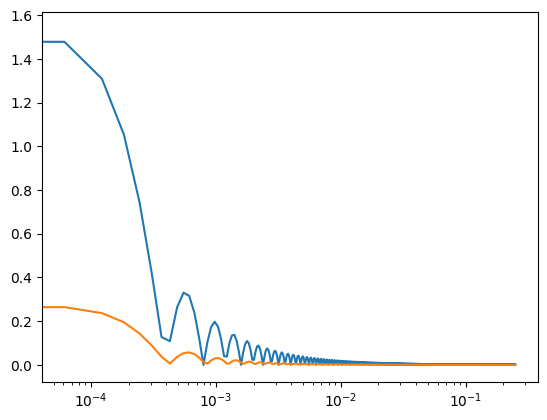

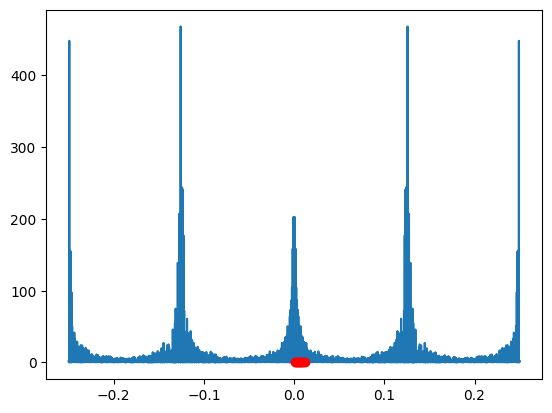

In [243]:
N = 2**13
u1_jw = fft.fft(u1, n = N)
y11_jw = fft.fft(y11, n = N)

y11_abs = np.abs(y11_jw) / N
u1_abs = np.abs(u1_jw) / N

freq = fft.fftfreq(N, d=2) 
freq = fft.fftshift(freq)

y11_abs_ = fft.fftshift(y11_abs)

plt.semilogx(freq[N//2:], u1_abs[:N//2])
plt.semilogx(freq[N//2:], y11_abs[:N//2])
# plt.semilogx(freq[N//2:], y11_abs_[N//2:], '-.') # eh o mesmo que fazer o de cima

g11_abs = y11_abs / u1_abs
print(g11_abs[0], g11_abs[-1])
g11_abs_ = fft.fftshift(g11_abs) / g11_abs[-1]

plt.figure()
plt.plot(freq, g11_abs_)

for i in range(10):
    f_d = w_d[i] / (2*np.pi)
    print(f_d)
    plt.plot(f_d, abs(a_ns[i]), 'or')

In [209]:
w_d

[0.007257086286878709,
 0.014514172573757419,
 0.021771258860636127,
 0.029028345147514838,
 0.03628543143439355,
 0.04354251772127225,
 0.050799604008150964,
 0.058056690295029675,
 0.06531377658190839,
 0.0725708628687871]

C:\Users\willi\AppData\Local\Temp\ipykernel_1940\1822415972.py:21: RuntimeWarning: divide by zero encountered in divide
  G11_abs = y11_jw / (u1_jw)
C:\Users\willi\AppData\Local\Temp\ipykernel_1940\1822415972.py:21: RuntimeWarning: invalid value encountered in divide
  G11_abs = y11_jw / (u1_jw)
C:\Users\willi\AppData\Local\Temp\ipykernel_1940\1822415972.py:23: RuntimeWarning: divide by zero encountered in divide
  G21_abs = y21_jw / (u1_jw)
C:\Users\willi\AppData\Local\Temp\ipykernel_1940\1822415972.py:23: RuntimeWarning: invalid value encountered in divide
  G21_abs = y21_jw / (u1_jw)
C:\Users\willi\AppData\Local\Temp\ipykernel_1940\1822415972.py:19: RuntimeWarning: divide by zero encountered in divide
  return p / q
C:\Users\willi\AppData\Local\Temp\ipykernel_1940\1822415972.py:19: RuntimeWarning: invalid value encountered in divide
  return p / q


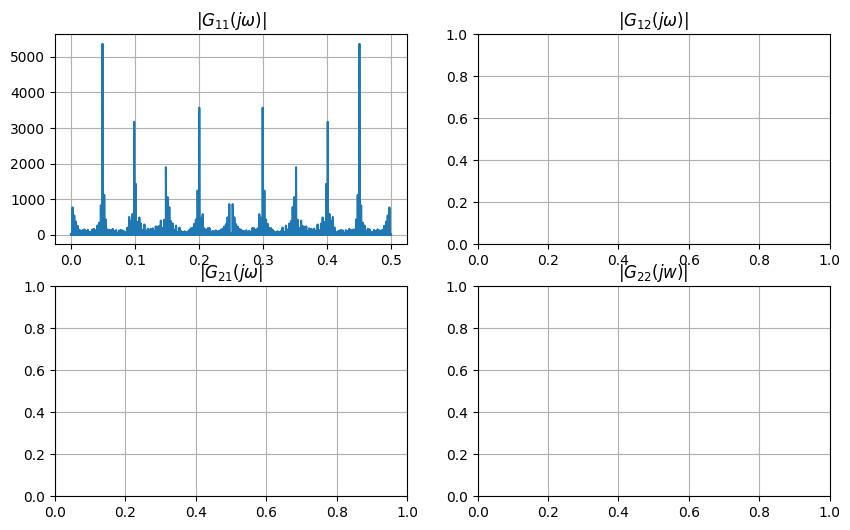

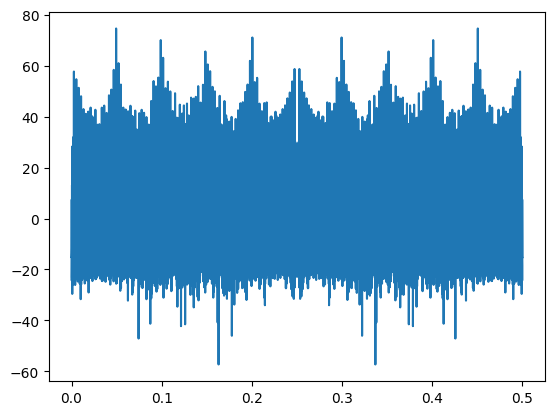

In [181]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

ax_G11, ax_G12, ax_G21, ax_G22 = axes.ravel()
titles = ['|G_{11}(j\omega)|', '|G_{12}(j\omega)|', '|G_{21}(j\omega|', '|G_{22}(jw)|']
for i, ax in enumerate(axes.ravel()):
    ax.set_title('$' + titles[i] + '$')
    ax.grid(True)

idx1 = idx2 = len(omega)

def freq_corte(x_abs):
    x_db = 20*np.log10(x_abs)
    idx = np.abs(x_db - (x_db[0] - 3)).argmin()
    return idx

def man(y, u, idx):
    p = y[:idx]
    q = u[:idx]
    return p / q

G11_abs = y11_jw / (u1_jw) 
G12_abs = y12_jw / (u2_jw)
G21_abs = y21_jw / (u1_jw)
G22_abs = y22_jw / (u2_jw)

# omega = fft.fftfreq(N, d=2.0)
# omega = fft.fftshift(omega) 

idx0 = 0
# idx0 = np.abs(omega - 0).argmin()
idx = np.abs(omega - 3*1e-4).argmin()
idx1 = idx2 = idx

# print(idx)
idx1 = idx2 = len(omega)
# idx1 = idx2 = 20000

ax_G11.plot(omega[L], np.abs(G11_abs[L]))
# ax_G11.plot(np.abs(G12_abs[L]))
# ax_G11.plot(np.abs(G21_abs[L]))
# ax_G11.plot(np.abs(G22_abs[L]))

plt.figure()
# plt.semilogx(u1_abs[:])
# plt.plot(omega, np.abs(man(y11_jw, u1_jw, N))/1.0)
plt.plot(omega, 20*np.log10(np.abs(man(y11_jw, u1_jw, N)))/1.0)
# plt.plot(omega, np.abs((y11_abs / u1_abs)))

In [84]:
G11[L]

array([ 0.15972393-3.70712187e-04j,  0.1597233 -7.41462953e-04j,
        0.15972224-1.11229101e-03j, ..., -0.02741693+2.97678392e-01j,
       -0.02742271+4.47608487e-01j, -0.02742618+8.96525300e-01j])

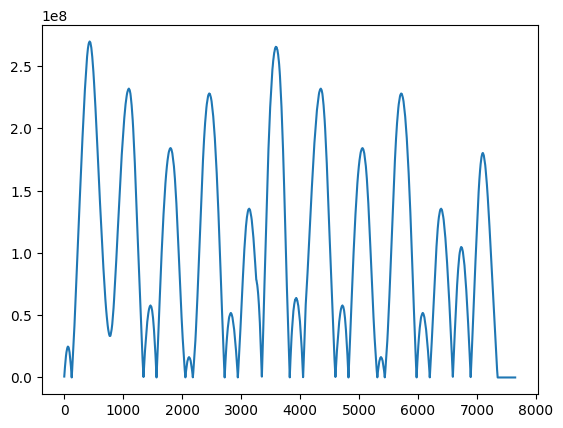

In [151]:

g11 = fft.ifft(G11).real


y11_estimado = np.convolve(g11, u1)

plt.plot(abs(y11_estimado))

In [95]:
print(idx0)
print(idx1)

65535
65536
